In [ ]:
script_path = "/n/home02/amphillips/binaries_in_streams/scripts" # for cannon
import sys
import petar
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.units as u
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from astropy.table import Table
from scipy.stats import binned_statistic_2d

import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

from gala.units import galactic

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib import gridspec
from matplotlib.lines import Line2D


from tqdm import tqdm

import pandas as pd

sys.path.append(script_path)
import PETAR_ANALYSIS_FUNCTIONS as paf
import astropy.constants as const
from streamframe import StreamFrame
from scipy.stats import binned_statistic
from matplotlib.gridspec import GridSpecFromSubplotSpec

import matplotlib.pyplot as plt
plt.style.use(script_path+'/vedant.mplstyle')
%config InlineBackend.figure_format='retina'

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap
from scipy.optimize import curve_fit
from scipy.stats import binom


import io
from matplotlib.transforms import Bbox


/n/home02/amphillips/.conda/envs/petar_env/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [ ]:
paths = paf.define_paths()
simcolm_colors, hm_colors, simcolors = paf.define_simcolors()
time_cmap = paf.define_time_cmap()

init_displacements = paf.define_init_displacements()
apocenters = paf.define_apocenters()

dissolution_times, plotting_times_peri, plotting_times_apo = paf.get_tdis_tplot(paths)

0 13388 13388 13388
1 12893 12893 12893
2 10784 10784 10784
3 7298 7298 7298
4 13929 13929 13929
5 4885 4885 4885
6 7365 7365 7365
7 3065 3065 3065
8 10853 10499 10746
9 5929 5552 5798
10 11430 10990 11230
11 4321 4081 3834
12 10928 10488 10735
13 3354 3096 3342
14 7004 6549 6797
15 2468 2108 2354
16 5405 5164 5311
17 2399 2255 2110
18 5381 5169 5316
19 2776 2546 2693
20 3956 3710 3857
21 1364 1090 1236
22 2341 2257 2111
23 1315 1089 1235


In [3]:
# colors_list = ["#87BBA2","#456A64","#244245", "#031926"]  
colors_list = ['k','0.2','0.4','0.6']
colors_list.reverse()

colors_list = ['#E3F4C8','#B6D6CC',
               '#74A4BC', '#29339B']
labels_list = ["all particle data", "detected binaries with 2 RVs", 
               "detected binaries with 3 RVs", "intrinsic dispersion"]

# outcomes for the P and K distributions w detections

In [3]:
def get_binary_coords(path, i):
    core = petar.Core(interrupt_mode='bse', external_mode='galpy')
    core.loadtxt(path+"data.core")
    core_pos = core.pos[i] * u.pc.to(u.kpc) # dimensionless core position in kpc
    core_vel = core.vel[i] * (u.pc/u.Myr).to(u.kpc/u.Myr) # dimensionless core velocity in kpc/myr
    core_w_jake_units = np.hstack([core_pos, core_vel])

    binaries = petar.Binary(member_particle_type=petar.Particle, G=petar.G_MSUN_PC_MYR,
                            interrupt_mode='bse', external_mode='galpy')
    binaries.loadtxt(path+"data.%i.binary"%i)#, skiprows=1)
    binary_pos = binaries.pos*u.pc.to(u.kpc)+core_pos
    binary_vel = binaries.vel*(u.pc/u.Myr).to(u.kpc/u.Myr)+core_vel
    binary_w = np.hstack([binary_pos, binary_vel])



    binary_stream_obj = StreamFrame(sim_coords=binary_w, prog_sim_coord=core_w_jake_units)
    binary_coords = binary_stream_obj.GetStreamFrame()
    return binary_coords

100%|██████████| 2123/2123 [00:00<00:00, 7394.82it/s]


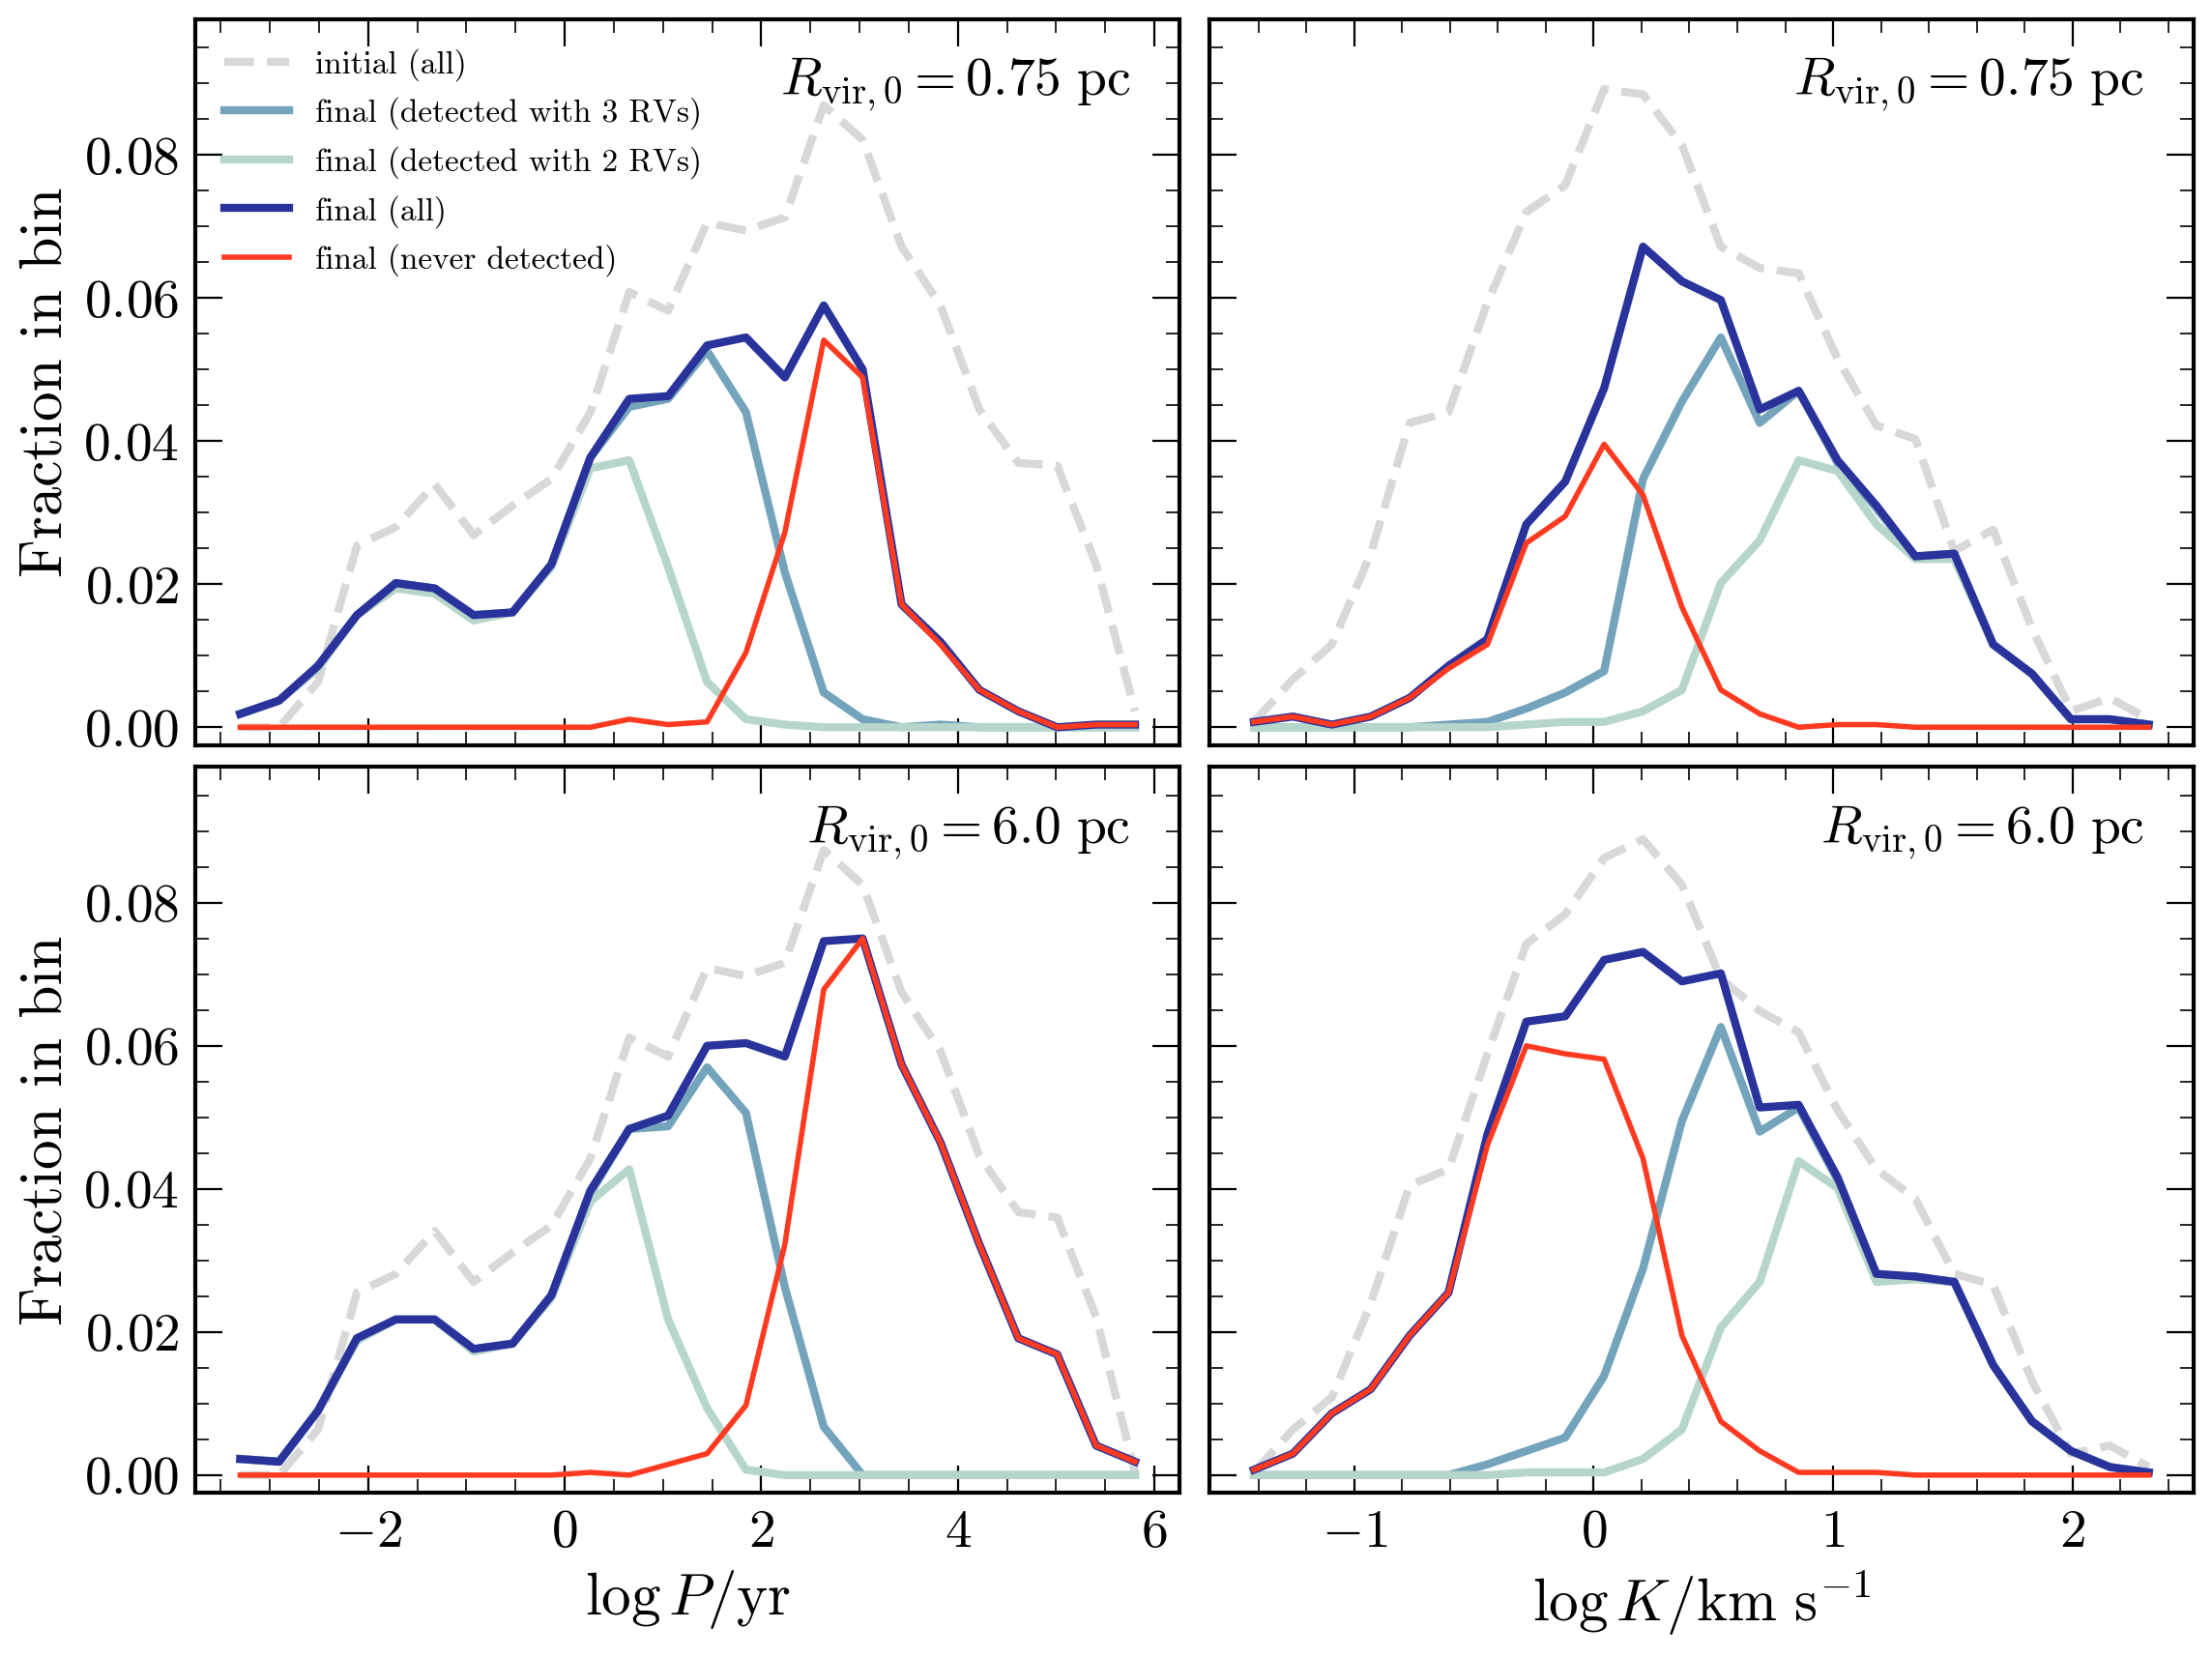

In [5]:
n_list = [8,14]
# labels = ["Low"]

fig, axs_grid = plt.subplots(len(n_list), 2, figsize=[2*20/3,60*0.66/4], sharey=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

for i in [0,1]:
    axs_grid[0,i].text(0.95, 0.95, r"$R_{\rm vir,0}=0.75\ \rm pc$", ha='right', va='top',
                        transform=axs_grid[0,i].transAxes, fontsize=20)
    axs_grid[1,i].text(0.95,0.95, r"$R_{\rm vir,0}=6.0\ \rm pc$", ha='right', va='top',
                    transform=axs_grid[1,i].transAxes, fontsize=20)

mass_cut = 0.0
for k, n in enumerate(n_list):
    axs = axs_grid[k]
    if k==0:
        for ax in axs:
            ax.set_xticklabels([])
    rng = np.random.default_rng(seed=42)
    path = paths[n]

    # load initial binaries and get their periods
    binaries0 = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binaries0.loadtxt(path+"data.0.binary")
    m, a = binaries0.mass*u.Msun, binaries0.semi*u.pc
    P0 = paf.calc_P(a, m).to(u.yr).value
    incs_init = paf.draw_inclinations(len(P0), rng)
    K0 = np.array([paf.calc_amplitude(binary, i) for binary, i in zip(binaries0, incs_init)]) * u.m/u.s
    K0 = K0.to(u.km/u.s).value
    select_mass0 = np.maximum(binaries0.p1.mass, binaries0.p2.mass) >= mass_cut
                
    # load final binaries, get their periods, run the mock surveys
    binariesf = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binariesf.loadtxt(path+"data.%i.binary"%plotting_times_peri[n])
    params_all_final, _ = paf.get_orbital_params(paths, plotting_times_peri, n, rng=rng)
    Pf = params_all_final[:,-1]*u.day.to(u.yr)
    Kf = params_all_final[:,1]
    obstimes_all_final = paf.get_obstimes(N_obsm=3, N=len(params_all_final), rng=rng)
    rvs_all_final = paf.get_rvs(params_all_final, obstimes_all_final)
    detected_3, dvs3 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_final, 
        v0_vals = params_all_final[:,0]*u.km/u.s,
        bool_arr = 'detet'
    )
    detected_2, dvs2 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_final[:,:-1], 
        v0_vals = params_all_final[:,0]*u.km/u.s,
        bool_arr = 'detet'
    )


    primary_masses = np.maximum(binariesf.p1.mass, binariesf.p2.mass)
    select_mass = primary_masses>=mass_cut # msun

    ##### OKAY BUT WAIT I ALSO WANT TO TRIM THE STREAM SO THAT IT'S THE SAME DATA AS IN THE FBIN MEGAPLOT FIGS!!!
    bcoords = get_binary_coords(path, plotting_times_peri[n])
    phi1, phi2, r, vr, apo = bcoords['phi1'], bcoords['phi2'], bcoords['r'], bcoords['vr'], apocenters[n]
    phi1, phi2, r, vr, in_mw, final_clip = paf.trim_stream_data(phi1, phi2, r, vr, apo)

    detected3_in_MW = detected_3[in_mw]
    detected2_in_MW = detected_2[in_mw]
    mass_selection_in_mw = select_mass[in_mw]

    # print(len(in_mw), len(final_clip))

    # additional flags for dynamical removal (aside from detection)
    id1s_0 = binaries0.p1.id
    id1s_f = binariesf.p1.id
    survives_flag = np.isin(id1s_0, id1s_f) # survives if the initial ID makes it into the final ID.

    bins = np.linspace(-3.5, 6, 25)
    bin_centers = (bins[1:]+bins[:-1])/2



    N_init = P0[select_mass0].size
    ax = axs[0]
    hist_initial,_ = np.histogram(np.log10(P0[select_mass0]), bins, weights=np.ones(N_init)/N_init)
    ax.plot(bin_centers, hist_initial, label="initial (all)", linestyle="--", color="0.5", alpha=0.3)

    hist_final_detected3, _ = np.histogram(np.log10(Pf[in_mw][detected3_in_MW & mass_selection_in_mw & final_clip]), bins,
                                           weights=np.ones(Pf[in_mw][detected3_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final_detected3, label="final (detected with 3 RVs)", color=colors_list[2])


    hist_final_detected2,_ = np.histogram(np.log10(Pf[in_mw][detected2_in_MW & mass_selection_in_mw & final_clip]), bins,
                                          weights=np.ones(Pf[in_mw][detected2_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final_detected2, label="final (detected with 2 RVs)",color=colors_list[1])

    hist_final,_ = np.histogram(np.log10(Pf[in_mw][mass_selection_in_mw & final_clip]), bins,
                                weights=np.ones(Pf[in_mw][mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final, label="final (all)", color=colors_list[3])

    hist_undetected, _ = np.histogram(np.log10(Pf[in_mw][~detected3_in_MW & mass_selection_in_mw & final_clip]), 
                                      bins,weights=np.ones(Pf[in_mw][~detected3_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_undetected, label="final (never detected)", c="#FF3A20", linestyle="-", linewidth=2)


    if k==0:
        bb=ax.get_position()
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, 
                loc='upper left',
                bbox_to_anchor=(bb.x0, bb.y1),
                bbox_transform=fig.transFigure,
                fontsize=12)

    if k==1:
        ax.set_xlabel(r"$\log P/\rm{yr} $")
    ax.set_ylabel(r"Fraction in bin")


    ax = axs[1]
    if k==1:
        ax.set_xlabel(r"$\log K/\rm km\ s^{-1} $")
    bins = np.linspace(-1.5, 2.4, 25)
    bin_centers = (bins[1:]+bins[:-1])/2

    hist_initial,_ = np.histogram(np.log10(K0[select_mass0]), bins, weights=np.ones(N_init)/N_init)
    ax.plot(bin_centers, hist_initial, label="initial (all)", linestyle="--", color="0.5", alpha=0.3)


    hist_final_detected3, _ = np.histogram(np.log10(Kf[in_mw][detected3_in_MW & mass_selection_in_mw & final_clip]), bins, 
                                           weights=np.ones(Kf[in_mw][detected3_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final_detected3, label="final (detected with 3 RVs)", color=colors_list[2])


    hist_final_detected2,_ = np.histogram(np.log10(Kf[in_mw][detected2_in_MW & mass_selection_in_mw & final_clip]), bins,
                                           weights=np.ones(Kf[in_mw][detected2_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final_detected2, label="final (detected with 2 RVs)",color=colors_list[1])

    hist_final,_ = np.histogram(np.log10(Kf[in_mw][mass_selection_in_mw & final_clip]), bins,
                                 weights=np.ones(Kf[in_mw][mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_final, label="final (all)", color=colors_list[3])

    hist_undetected, _ = np.histogram(np.log10(Kf[in_mw][~detected3_in_MW & mass_selection_in_mw & final_clip]), bins,
                                       weights=np.ones(Kf[in_mw][~detected3_in_MW & mass_selection_in_mw & final_clip].size)/N_init)
    ax.plot(bin_centers, hist_undetected, label="final (never detected)", c="#FF3A20", linestyle="-", linewidth=2)


    ax.set_ylim(-0.0025, 0.099)

# plt.savefig("plots/period_AND_K_distribution_with_outcomes.pdf", dpi=300, bbox_inches="tight")

# a summary of the whole grid

In [ ]:
####### LOAD INFORMATION ABOUT THE GRID ITSELF 
n_list = np.arange(0, 24, 1).astype(int)

kmeds = []
klos = []
kups = []
detection_fractions = []

in_undetected_binaries_fractions = []
in_undetected_binaries_fractions_initial = []

N_undetected_final = []
N_undetected_initial = []

for k, n in enumerate(n_list):
    print(n)
    rng = np.random.default_rng(seed=42)
    rng0 = np.random.default_rng(seed=41) # for the initial guys, so the final detection frac doesn't change.
    path = paths[n]

    # load initial binaries and get their periods, detection rates.
    singles0 = petar.Particle(interrupt_mode='bse', external_mode='galpy')
    singles0.loadtxt(path+"data.0.single")
    n_singles0 = len(singles0.mass)

    binaries0 = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binaries0.loadtxt(path+"data.0.binary")

    params_all_initial, _ = paf.get_orbital_params(paths, np.zeros(len(paths)).astype(int), n, rng=rng0)
    P0 = params_all_initial[:,-1]*u.day.to(u.yr)
    K0 = params_all_initial[:,1]
    obstimes_all_initial = paf.get_obstimes(N_obsm=3, N=len(params_all_initial), rng=rng0)
    rvs_all_initial = paf.get_rvs(params_all_initial, obstimes_all_initial)
    detected_30, dvs30 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_initial, 
        v0_vals = params_all_initial[:,0] * u.km/u.s, 
        bool_arr = 'detet'
    )
    
    n_undetected0 = len(P0[~detected_30])
    N_undetected_initial.append(n_undetected0)
    n_binaries0 = len(P0)
    frac_undetected_0 = n_undetected0 / (n_singles0 + n_binaries0)
    in_undetected_binaries_fractions_initial.append(frac_undetected_0)


            
    # load final binaries, get their periods, run the mock surveys
    singlesf = petar.Particle(interrupt_mode='bse', external_mode='galpy')
    singlesf.loadtxt(path+"data.%i.single"%plotting_times_peri[n])
    n_singles = len(singlesf.mass)

    binariesf = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binariesf.loadtxt(path+"data.%i.binary"%plotting_times_peri[n])
    params_all_final, _ = paf.get_orbital_params(paths, plotting_times_peri, n, rng=rng)
    Pf = params_all_final[:,-1]*u.day.to(u.yr)
    Kf = params_all_final[:,1] # KF!!!
    obstimes_all_final = paf.get_obstimes(N_obsm=3, N=len(params_all_final), rng=rng)
    rvs_all_final = paf.get_rvs(params_all_final, obstimes_all_final)
    detected_3, dvs3 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_final, 
        v0_vals = params_all_final[:,0]*u.km/u.s,
        bool_arr = 'detet'
    )

    undetected_amps = np.log10(Kf[~detected_3])
    n_binaries = len(Kf)
    n_undetected = len(Kf[~detected_3])
    N_undetected_final.append(n_undetected)


    detection_fraction = len(Kf[detected_3])/len(Kf)
    detection_fractions.append(detection_fraction)

    frac_in_undetected_binaries = n_undetected / (n_singles+n_binaries)
    in_undetected_binaries_fractions.append(frac_in_undetected_binaries)

    k16 = np.percentile(10**undetected_amps, 16)
    k84 = np.percentile(10**undetected_amps, 84)
    kmed = np.median(10**undetected_amps)
    kmeds.append(kmed)
    klos.append(k16)
    kups.append(k84)

kmeds = np.array(kmeds)
klos = np.array(klos)
kups = np.array(kups)

detection_fractions = np.array(detection_fractions)
in_undetected_binaries_fractions = np.array(in_undetected_binaries_fractions)
in_undetected_binaries_fractions_initial = np.array(in_undetected_binaries_fractions_initial)

N_undetected_final = np.array(N_undetected_final)
N_undetected_initial = np.array(N_undetected_initial)

0


100%|██████████| 1427/1427 [00:00<00:00, 4924.49it/s]


1


100%|██████████| 1605/1605 [00:00<00:00, 7064.30it/s]


2


100%|██████████| 1678/1678 [00:00<00:00, 7260.54it/s]


3


100%|██████████| 1896/1896 [00:00<00:00, 6134.34it/s]


4


100%|██████████| 1793/1793 [00:00<00:00, 6845.24it/s]


5


100%|██████████| 2091/2091 [00:00<00:00, 6788.95it/s]


6


100%|██████████| 2130/2130 [00:00<00:00, 7209.37it/s]


7


100%|██████████| 2230/2230 [00:00<00:00, 6914.68it/s]


8


100%|██████████| 1549/1549 [00:00<00:00, 7299.88it/s]


9


100%|██████████| 1715/1715 [00:00<00:00, 4866.74it/s]


10


100%|██████████| 1666/1666 [00:00<00:00, 6847.53it/s]


11


100%|██████████| 1909/1909 [00:00<00:00, 7266.53it/s]


12


100%|██████████| 1894/1894 [00:00<00:00, 5911.07it/s]


13


100%|██████████| 2143/2143 [00:00<00:00, 7309.10it/s]


14


100%|██████████| 2123/2123 [00:00<00:00, 5804.47it/s]


15


100%|██████████| 2282/2282 [00:00<00:00, 6915.71it/s]


16


100%|██████████| 1630/1630 [00:00<00:00, 5780.88it/s]


17


100%|██████████| 1800/1800 [00:00<00:00, 7008.24it/s]


18


100%|██████████| 1781/1781 [00:00<00:00, 5900.05it/s]


19


100%|██████████| 1945/1945 [00:00<00:00, 6984.25it/s]


20


100%|██████████| 2018/2018 [00:00<00:00, 6375.57it/s]


21


100%|██████████| 2225/2225 [00:00<00:00, 7340.62it/s]


22


100%|██████████| 2270/2270 [00:00<00:00, 7441.82it/s]


23


100%|██████████| 2337/2337 [00:00<00:00, 7320.29it/s]


In [16]:
### LOAD INFORMATION FROM THE HIGH BINARY FRACTION SIMS!!! 
ph_high_lm = "/n/netscratch/conroy_lab/Lab/amphillips/high_lowmass_fbin_tests/14/"
ph_high = "/n/netscratch/conroy_lab/Lab/amphillips/high_fbin_tests/8/"

paths_high = [ph_high_lm, ph_high]
labels = ['only double low mass', 'double everything']


iplots = []
for j, ph_high in enumerate(paths_high):
    # print("\t\t"+ph_high)
    print('\t'+labels[j])
    # find dissolution / plotting time ! 
    tidal = paf.load_tidal(ph_high)
    bound_times = tidal.time[tidal.n>=100]
    tdis = int(max(bound_times))

    core = petar.Core(interrupt_mode='bse', external_mode='galpy')
    core.loadtxt(ph_high+"data.core")
    x,y,z = core.pos.T
    r = np.sqrt(x**2 + y**2 + z**2)

    # plt.plot(tidal.time, r)

    i_dis = int(tdis/10)
    r_times_to_check = tidal.time[i_dis-100:i_dis].astype(int) 
    r_inds_to_check = r_times_to_check / 10
    r_inds_to_check = r_inds_to_check.astype(int) 
    rs_to_check = r[r_inds_to_check]

    min_inds, min_vals = paf.find_minima(rs_to_check)
    times_at_minimum = r_times_to_check[min_inds]
    inds_at_minimum = r_inds_to_check[min_inds] 

    max_inds, max_vals = paf.find_maxima(rs_to_check)
    times_at_maximum = r_times_to_check[max_inds]
    inds_at_maximum = r_inds_to_check[max_inds]

    tplot_p = int(max(times_at_minimum))
    tplot_a = int(max(times_at_maximum))     


    iplot_p = int(tplot_p/10)
    idis = int(tdis/10) 
    iplots.append(iplot_p)


    
    ############ other information to print for table 1 in the paper:
    # initial half-mass radius
    # N_OB and M_OB
    # initial clsuter mass
    # initial dynamical, relaxation timescales
    # initial velocity dispersion
    rh, nbound, mbound, t_rh, t_dyn, t_dis = paf.compute_cluster_structure(
        ph_high, i_list=np.zeros(1).astype(int), init_displacement = None,
        density_shell_width=0.5
    )



    # load particle info at data.0:
    all_particles, binaries, singles, coords, single_coords, binary_coords = paf.load_coords(
        ph_high, i=0, return_all_particles=True, return_single_particles=True
        )
    all_masses = all_particles.mass
    Mtot = np.sum(all_masses)

    OB_flag = all_masses>=8
    NOB = len(all_masses[OB_flag])
    MOB = np.sum(all_masses[OB_flag])


    # half mass radius
    x,y,z = all_particles.pos.T
    r = np.sqrt(x**2 + y**2 + z**2)
    RH = paf.calculate_half_mass_radius(all_masses, r)


    # velocity dispersion in core frame
    svx, svy, svz = singles.vel.T * u.pc/u.Myr
    sv = np.sqrt(svx**2 + svy**2 + svz**2)
    bvx, bvy, bvz = binaries.vel.T * u.pc/u.Myr
    bv = np.sqrt(bvx**2 + bvy**2 + bvz**2)

    all_v = np.concatenate([sv, bv])
    sigma_v = paf.calc_dispersion(all_v)
    sigma_1D = sigma_v / np.sqrt(3)

    ### print everything
    print("Rh0:", round(RH,2))
    print("N_OB:", round(NOB,0))
    print("M_OB:", round(MOB,0))
    print("Mclust:", np.round(Mtot,0))
    print("t_dyn0: ", round(t_dyn[0],1))
    print("t_rh0:", round(t_rh[0],0))
    print("sigma_1D:", sigma_1D.to(u.km/u.s))
    print("t_dis:", tdis)
    print("t_peri:", tplot_p)


	only double low mass


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Rh0: 1.27
N_OB: 94
M_OB: 1776.0
Mclust: 8823.0
t_dyn0:  1.0
t_rh0: 155.0
sigma_1D: 1.055185740043762 km / s
t_dis: 9380
t_peri: 9010
	double everything


100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


Rh0: 1.28
N_OB: 147
M_OB: 2895.0
Mclust: 11184.0
t_dyn0:  0.9
t_rh0: 138.0
sigma_1D: 1.3732627983073662 km / s
t_dis: 7330
t_peri: 7050


In [ ]:
# For this bonus sim, what is N_undetected, i and N_undetected, f
depletion_fractions_high = []

kmeds_high = []
klos_high = []
kups_high = []

for j, ph_high in enumerate(paths_high):
    iplot_p = iplots[j]
    path = ph_high

    rng = np.random.default_rng(seed=42)
    rng0 = np.random.default_rng(seed=41) # for the initial guys, so the final detection frac doesn't change.

    # load initial binaries and get their periods, detection rates.
    singles0 = petar.Particle(interrupt_mode='bse', external_mode='galpy')
    singles0.loadtxt(path+"data.0.single")
    n_singles0 = len(singles0.mass)

    binaries0 = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binaries0.loadtxt(path+"data.0.binary")

    params_all_initial, _ = paf.get_orbital_params(paths = [path],
                                                   times = np.zeros(1).astype(int),
                                                     n=0,
                                                       rng=rng0)
    P0 = params_all_initial[:,-1]*u.day.to(u.yr)
    K0 = params_all_initial[:,1]
    obstimes_all_initial = paf.get_obstimes(N_obsm=3, N=len(params_all_initial), rng=rng0)
    rvs_all_initial = paf.get_rvs(params_all_initial, obstimes_all_initial)
    detected_30, dvs30 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_initial, 
        v0_vals = params_all_initial[:,0] * u.km/u.s, 
        bool_arr = 'detet'
    )
        
    N_un_i_high = len(P0[~detected_30]) # number of undetectable binaries at the initial time

                
    # load final binaries, get their periods, run the mock surveys
    singlesf = petar.Particle(interrupt_mode='bse', external_mode='galpy')
    singlesf.loadtxt(path+"data.%i.single"%iplot_p)
    n_singles = len(singlesf.mass)

    binariesf = petar.Binary(member_particle_type=petar.Particle, interrupt_mode='bse', external_mode='galpy')
    binariesf.loadtxt(path+"data.%i.binary"%iplot_p)
    params_all_final, _ = paf.get_orbital_params([path], [iplot_p], 0, rng=rng)
    Pf = params_all_final[:,-1]*u.day.to(u.yr)
    Kf = params_all_final[:,1] # KF!!!
    obstimes_all_final = paf.get_obstimes(N_obsm=3, N=len(params_all_final), rng=rng)
    rvs_all_final = paf.get_rvs(params_all_final, obstimes_all_final)
    detected_3, dvs3 = paf.get_detections(
        e_rv=0.1, 
        rvs_all = rvs_all_final, 
        v0_vals = params_all_final[:,0]*u.km/u.s,
        bool_arr = 'detet'
    )

    undetected_amps = np.log10(Kf[~detected_3])
    # statistics of the undetected amps.
    kmeds_high.append(np.median(10**undetected_amps))
    k16= np.percentile(10**undetected_amps, 16)
    k84 = np.percentile(10**undetected_amps, 84)
    klos_high.append(k16)
    kups_high.append(k84)


    N_un_f_high = len(Kf[~detected_3])

    f_depletion_high = N_un_f_high / N_un_i_high
    depletion_fractions_high.append(f_depletion_high)

depletion_fractions_high = np.array(depletion_fractions_high)
kmeds_high = np.array(kmeds_high)
klos_high = np.array(klos_high)
kups_high = np.array(kups_high)

100%|██████████| 3177/3177 [00:00<00:00, 7526.74it/s]


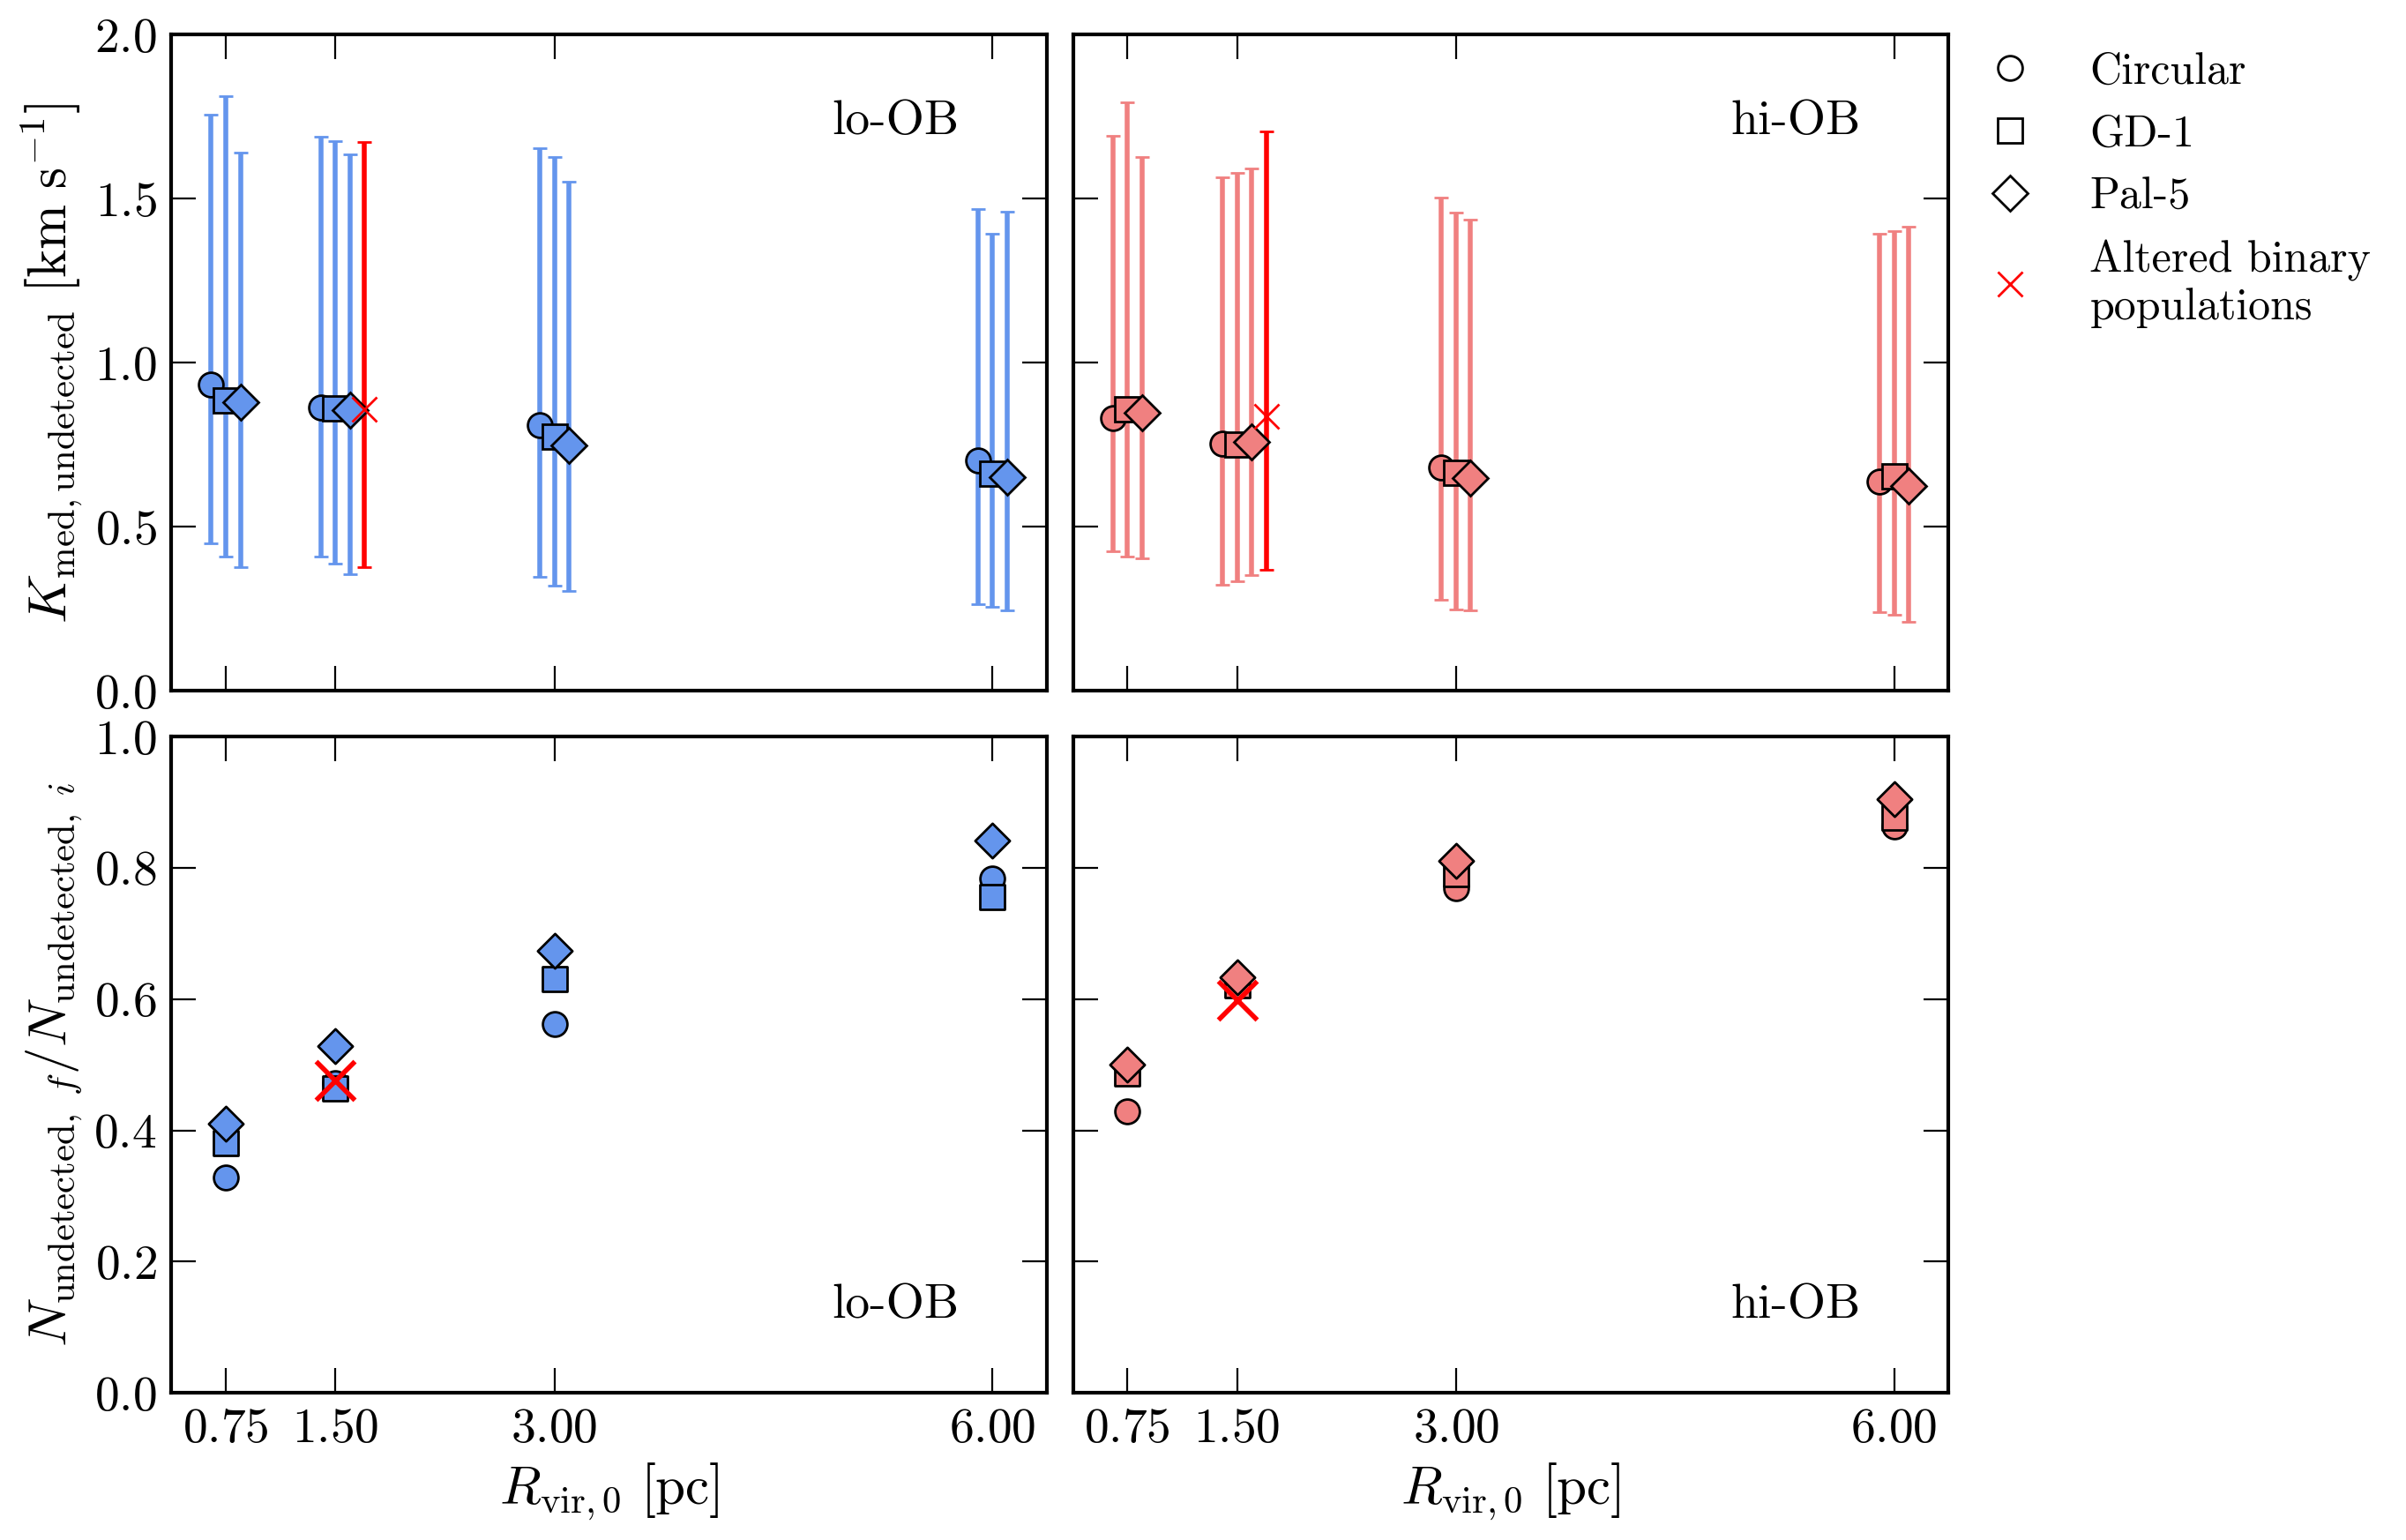

In [91]:
fig, axs_grid = plt.subplots(2,2,figsize=[13,10], sharex=True)#, sharey=True)
plt.subplots_adjust(hspace=0.07, wspace=0.03)


shapes = ['o','s','D']
facecolors = ['cornflowerblue', 'lightcoral']
axs[0].set_xlim(0.3,6.5)
rvirs = [0.75]*2 + [1.5]*2 + [3.0]*2 + [6.0]*2
rvirs*=3
rvirs = np.array(rvirs)

offsets = [-0.1]*8 + [0.0]*8 + [0.1]*8
offsets = np.array(offsets)

n_subsets = [[[0,2,4,6], [1,3,5,7]],
              [[8,10,12,14],[9,11,13,15]],
              [[16,18,20,22],[17,19,21,23]]
              ]

################################################################
#     panel 1: typical amplitudes of undeteted binaries.
###############################################################
axs = axs_grid[0] # first row -- undetected amplitudes. 

for k, orbit in enumerate(n_subsets):
    for kk, n_subset in enumerate(orbit):
        ax = axs[kk]
        x = rvirs[n_subset] + offsets[n_subset]
        ax.errorbar(x, kmeds[n_subset], yerr=[kmeds[n_subset]-klos[n_subset], kups[n_subset]-kmeds[n_subset]],
                     marker=shapes[k], markersize=10, markerfacecolor=facecolors[kk], color=facecolors[kk],
                     markeredgecolor='k', capsize=3, linestyle='', linewidth=2)
axs[0].set_ylabel(r"$K_{\rm med, undetected}\ [\rm km\ s^{-1}]$")


############################## add the bonus sims here: ################################
axs[0].errorbar([1.5+0.2], [kmeds_high[0]], 
                yerr=[
                    [kmeds_high[0]-klos_high[0]],
                    [kups_high[0] - kmeds_high[0]]
                ],
                marker='x', markersize=10, linewidth=2, capsize=3, color='r')

axs[1].errorbar([1.5+0.2], [kmeds_high[1]], 
                yerr=[
                    [kmeds_high[1]-klos_high[1]],
                    [kups_high[1] - kmeds_high[1]]
                ],
                marker='x', markersize=10, linewidth=2, capsize=3, color='r')



# build proxy artists for the legend
legend_elements = [
    Line2D([0], [0], marker='o', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           markersize=10, label='Circular'),
    Line2D([0], [0], marker='s', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           markersize=10, label='GD-1'),
    Line2D([0], [0], marker='D', linestyle='None',
           markerfacecolor='white', markeredgecolor='black',
           markersize=10, label='Pal-5'),
    Line2D([0], [0], marker='x', linestyle='None', linewidth=1, 
           markersize=10, markeredgecolor='r',
           label='Altered binary\npopulations')
]

# place the legend on the right side of the right subplot
axs[1].legend(handles=legend_elements,
              loc='upper left',
              bbox_to_anchor=(1.0, 1),
              borderaxespad=0.)#,
            #   title="Orbit")

axs[0].text(0.9,0.9, "lo-OB", #r"$N_{\rm OB}=86$",
 ha='right', va='top', fontsize=20,
           transform=axs[0].transAxes)
axs[1].text(0.9,0.9, "hi-OB", #r"$N_{\rm OB}=137$",
 ha='right', va='top',fontsize=20,
           transform=axs[1].transAxes)

# axs[0].set_ylim(0.6, 1)
for ax in axs:
    ax.set_xticks([0.75, 1.5, 3., 6.])
    ax.minorticks_off()
    ax.set_ylim(0, 2)



################################################################################
#      bottom row: depletion fraction for undetectable binaries
################################################################################
axs = axs_grid[1]

for k, orbit in enumerate(n_subsets):
    for kk, n_subset in enumerate(orbit):
        ax = axs[kk]

        y = N_undetected_final[n_subset] / N_undetected_initial[n_subset]

        ax.scatter(rvirs[n_subset], y, marker=shapes[k], s=100, facecolor=facecolors[kk], edgecolor='k')
        ax.set_xlabel(r"$R_{\rm vir, 0}\ \rm [pc]$")

axs[0].set_ylabel(r'$N_{\mathrm{undetected},\ f} / N_{\mathrm{undetected},\ i}$')


for k, fdep in enumerate(depletion_fractions_high):
    axs[k].scatter([1.5], [fdep], c='r', marker='x', s=250, lw=2)


axs[0].text(0.9,0.1, "lo-OB", #r"$N_{\rm OB}=86$",
 ha='right', va='bottom', fontsize=20,
           transform=axs[0].transAxes)
axs[1].text(0.9,0.1, "hi-OB", #r"$N_{\rm OB}=137$",
 ha='right', va='bottom',fontsize=20,
           transform=axs[1].transAxes)

for ax in axs:
    ax.set_xticks([0.75, 1.5, 3., 6.])
    ax.minorticks_off()
    ax.set_ylim(0,1)

ax.set_ylim(0, 1)

for ax in axs_grid[:,1]:
    ax.set_yticklabels([])


plt.savefig("plots/combined_amplitude_detection_summary_with_2xfbin_sims.pdf", dpi=300, bbox_inches='tight')